In [1]:
# ----------------------------------------------------------------
# IoT Netprofiler
# Licensed under The MIT License [see LICENSE for details]
# Written by Luca Maiano - https://www.linkedin.com/in/lucamaiano/
# ----------------------------------------------------------------

# Attack Detection

In this notebook we apply *learning algorithms* with the aim of detect attacks in an IoT network as accurately as possible. Particularly, we will focus on **supervised** and **unsupervised** algorithms. With this analysis, we want to compare the effectiveness of the following algorithms:
1. K-Nearest Neighbor (KNN)
2. Random Forests Classifier
3. Support Vector Machines (SVM)
5. Deep Neural Network Classifier 
6. K-Means

All mentioned algorithms have been extensively used by *state of the art* solutions in order to solve **anomaly-detection** problems [2].

## Metrics Identification

Using the same approach of Yavuz et al. [1], in order to deal with an imbalanced dataset we use AUC-ROC together with the following metrics:
1. 
$
\begin{align}
Precision = \frac{TP}{TP+FP}
\end{align}
$

2. 
$
\begin{align}
Recall = \frac{TP}{TP+FN}
\end{align}
$

3. 
$
\begin{align}
F1 = 2\frac{precision * recall}{precision+recall}
\end{align}
$
4. AUC-ROC. 

If the AUC-ROC is bigger than 0.5, it means that the model is better than random guessing.




In [1]:
import csv
import pandas as pd
import numpy as np
import sys, os

import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from lib.utils import trace_processing
from lib.visualization import data_visualization
from lib.analysis import trace_statistics
from lib.analysis import trace_classification


Using TensorFlow backend.


Let us start importing 2 sets of experiments:
1. *9 nodes* examples containing grids and random topologies;
2. *16 nodes* examples containing grids and random topologies.

In [2]:
exp_9_nodes = trace_processing.import_trace('data/experiments/cooja3-9nodes/traces/', 'traces.csv')
exp_16_nodes = trace_processing.import_trace('data/experiments/cooja3-16nodes/traces/', 'traces.csv')

experiments = exp_9_nodes + exp_16_nodes

# Experiment 1: Attacked vs Normal Behaviour

Now we import *features* and *normalize* the data to speedup the learning process. For this experiment, we consider just two classes:
1. **Normal** behaviour (0) meaning that the entire network is not under attack;
2. **Attacked** (1), i.e. an attack has been performed (Black Hole or Gray Hole).

In [3]:
data = None
n_classes = 2

for experiment in experiments:
    label = 0
    topology = experiment[0].split('/')[2].split('cooja3-')[1]
    experiment_id = topology + '/' + experiment[1]
    
    if n_classes == 2:
        # Assign a label
        if experiment[1].find('gh') >= 0 or experiment[1].find('bh') >= 0:
            label = 1
    else:
        # Assign a label
        if experiment[1].find('gh') >= 0:
            label = 1
        elif experiment[1].find('bh') >= 0:
            label = 2
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    
    if data is None:
        data = trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)    
    else:
        data = pd.concat([data, trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)])

data = data.sample(frac=1).reset_index(drop=True)
norm_data = trace_processing.feature_normalization(data, ['node', 'experiment', 'label'])
norm_data.head(5)

/Users/lucamaiano/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,node,experiment,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers,label
0,aaaa::212:740e:e:e0e:,16nodes/grid_1gh30-9_2019-02-20_00:12_,0.894625,0.883249,0.603327,0.064520,1.00,0.713200,0.539444,0.116751,0.6875,1
1,aaaa::212:7405:5:505:,9nodes/rnd_1gh-9_2019-02-16_10:36_,0.428974,0.517766,0.310919,0.041899,0.25,0.410656,0.275311,0.482234,0.3125,1
2,aaaa::212:7408:8:808:,16nodes/grid_normal_2019-02-19_21:23_,0.446005,0.477157,0.479775,0.351032,0.25,0.462354,0.641198,0.522843,0.1875,0
3,aaaa::212:740a:a:a0a:,9nodes/grid_1gh-5_2019-02-15_22:09_,0.865676,0.934010,0.465021,0.144251,0.75,0.536670,0.622278,0.065990,0.6250,1
4,aaaa::212:7405:5:505:,16nodes/grid_1gh50-9_2019-02-19_23:54_,0.718078,0.791878,0.433347,0.219362,0.25,0.449710,0.560131,0.208122,0.4375,1


Now we can split the dataset in *training and testing set*.

In [4]:
X = norm_data.drop(['node', 'experiment', 'label'], axis=1)
y = norm_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

X.head()

,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers
0,0.894625,0.883249,0.603327,0.064520,1.00,0.713200,0.539444,0.116751,0.6875
1,0.428974,0.517766,0.310919,0.041899,0.25,0.410656,0.275311,0.482234,0.3125
2,0.446005,0.477157,0.479775,0.351032,0.25,0.462354,0.641198,0.522843,0.1875
3,0.865676,0.934010,0.465021,0.144251,0.75,0.536670,0.622278,0.065990,0.6250
4,0.718078,0.791878,0.433347,0.219362,0.25,0.449710,0.560131,0.208122,0.4375


## Feature Selection

Starting from the results that we obtained during the data exploration phase, we can now start to train and compare the learning algorithms. The results will be compared with different sets of features. Features will be iteratively selected removing the most relevant and less relevant feature. Most significant feature is dropped to avoid *overfitting*, less relevant feature is dropped to avoid *underfitting*.

The experiment will be repeated iteratively following this way:
1. select a set of feature;
2. run learning algorithms;
3. measure performances.

At the end the best set of features will be selected. We start selecting the entire set of features.

### Supervised Algorithms

1. The first algorithm that we evaluate is **k-NN**.

In [5]:
knn_pred = trace_classification.k_nn_classifier(X_train, y_train, X_test, y_test, n_neighbors=3, cross_val=5)
knn_results, knn_confusion_matrix = trace_classification.test_metrics('knn', y_test, knn_pred)
knn_results

AUC on validation set 1/5: 0.726923076923077
AUC on validation set 2/5: 0.7455882352941177
AUC on validation set 3/5: 0.7208462332301342
AUC on validation set 4/5: 0.7373581011351908
AUC on validation set 5/5: 0.5825593395252838
Mean AUC 0.703 (Std +/- 0.061)


,model,accuracy,precision,recall,f1-score,auc roc
0,knn,0.775281,0.743894,0.71048,0.721875,0.71048


2. Now we evaluate **RandomForest Classifier**.

In [6]:
rfc_pred = trace_classification.random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=100, cross_val=5)
rfc_results, rfc_confusion_matrix = trace_classification.test_metrics('random forest', y_test, rfc_pred)
rfc_results

AUC on validation set 1/5: 0.6730769230769231
AUC on validation set 2/5: 0.6857843137254901
AUC on validation set 3/5: 0.5892672858617132
AUC on validation set 4/5: 0.7239422084623323
AUC on validation set 5/5: 0.5562435500515995
Mean AUC 0.556 (Std +/- 0.000)


,model,accuracy,precision,recall,f1-score,auc roc
0,random forest,0.786517,0.768421,0.709016,0.725353,0.709016


3. Prediction of **Support Vector Machines (SVM)**.

In [7]:
svm_pred = trace_classification.svm_classifier(X_train, y_train, X_test, y_test, kernel='linear', cross_val=5)
svm_results, svm_confusion_matrix = trace_classification.test_metrics('svm', y_test, svm_pred)
svm_results

AUC on validation set 1/5: 0.5403846153846154
AUC on validation set 2/5: 0.5
AUC on validation set 3/5: 0.5
AUC on validation set 4/5: 0.5
AUC on validation set 5/5: 0.5263157894736843
Mean AUC 0.513 (Std +/- 0.017)


,model,accuracy,precision,recall,f1-score,auc roc
0,svm,0.741573,0.863095,0.589286,0.572205,0.589286


4. Finally we implement **Deep Neural Networks**.

Mean Accuracy: 81.02% (2.43%)


,model,accuracy,precision,recall,f1-score,auc roc
0,neural network,0.797753,0.774084,0.736534,0.749688,0.736534


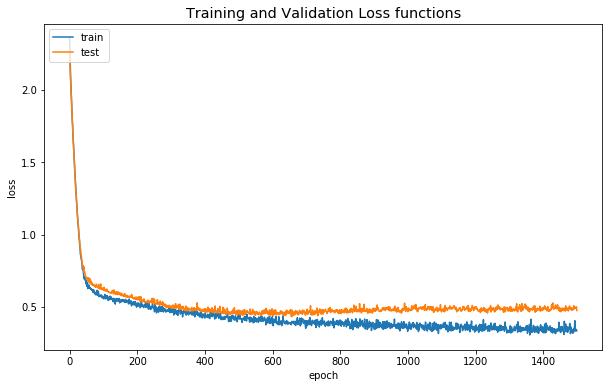

In [8]:
nn_pred = trace_classification.neural_net_classifier(X_train, y_train, X_test, y_test, '2classes')
nn_results, nn_confusion_matrix = trace_classification.test_metrics('neural network', y_test, nn_pred)
nn_results

### Unsupervised Algorithms

Now we can try to model the problem as an unsupervised learning problem. First, we apply a PCA transformation to collapse the set of datapoints to a 3D space.

In [9]:
X_pca = trace_classification.pca_transformation(X, n_components=len(X.columns)-2)
X_pca.head()

,0,1,2,3,4,5,6
0,0.366366,-0.615365,-0.179581,0.137254,0.116893,-0.002083,-0.000079
1,-0.042518,0.470628,-0.312472,0.018035,-0.116246,-0.012664,0.036034
2,0.259352,0.549548,0.080093,-0.108478,-0.007610,-0.018272,0.045985
3,0.120553,-0.452204,-0.004759,0.034268,0.160320,-0.077796,0.004455
4,-0.065940,0.053812,0.129635,-0.047188,-0.056473,-0.027058,0.021809


5. Let us try modeling the problem with **K-Means**.

,model,accuracy,precision,recall,f1-score,auc roc
0,kmeans,0.375566,0.39973,0.37812,0.359501,0.37812


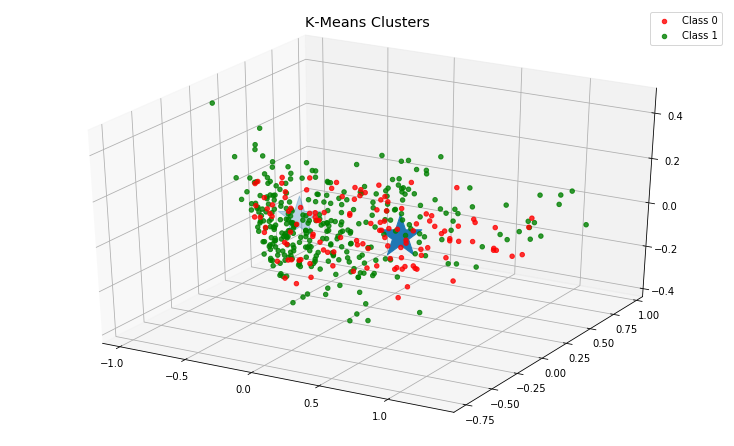

In [12]:
kmeans_pred, centroids = trace_classification.kmeans_classifier(X_pca, n_clusters=2)
data_visualization.plot_3d_points(X_pca[0], X_pca[1], X_pca[3], y, plot_name='KMeans_K2', centroids=centroids)
kmeans_results, kmeans_confusion_matrix = trace_classification.test_metrics('kmeans', y, kmeans_pred)
kmeans_results

## Conclusions

Let us compare the results obtained from the experiment.

In [11]:
final_results= pd.DataFrame(columns=['model','accuracy','precision','recall','f1-score','auc roc'])
final_results = pd.concat([final_results, knn_results])
final_results = pd.concat([final_results, rfc_results])
final_results = pd.concat([final_results, svm_results])
final_results = pd.concat([final_results, nn_results])
final_results = pd.concat([final_results, kmeans_results])
final_results.reset_index(drop=True)

,model,accuracy,precision,recall,f1-score,auc roc
0,knn,0.775281,0.743894,0.710480,0.721875,0.710480
1,random forest,0.786517,0.768421,0.709016,0.725353,0.709016
2,svm,0.741573,0.863095,0.589286,0.572205,0.589286
3,neural network,0.797753,0.774084,0.736534,0.749688,0.736534
4,kmeans,0.375566,0.399730,0.378120,0.359501,0.378120


Based on the table above, we see that the **neural network** outperform all the other models. **KNN** also achieve really good results follwed by *random forsests*.

# Experiment 2: Normal Behaviour vs Grey Hole vs Black Hole Attack

For this second scenario, we want to detect which attack has been performed (if any). Each node will be labeled as follows:
1. **Normal** behaviour (0) meaning that the entire network is not under attack;
2. **Grey Hole** (1);
3. **Black Hole** (2).

In [3]:
data = None
n_classes = 3

for experiment in experiments:
    label = 0
    topology = experiment[0].split('/')[2].split('cooja3-')[1]
    experiment_id = topology + '/' + experiment[1]
    
    if n_classes == 2:
        # Assign a label
        if experiment[1].find('gh') >= 0 or experiment[1].find('bh') >= 0:
            label = 1
    else:
        # Assign a label
        if experiment[1].find('gh') >= 0:
            label = 1
        elif experiment[1].find('bh') >= 0:
            label = 2
    nodes, packets_node = trace_processing.process_cooja_traces(experiment[0], experiment[1])
    
    if data is None:
        data = trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)    
    else:
        data = pd.concat([data, trace_processing.feature_extraction(nodes, packets_node, label, experiment_id, log_transform=True, window_size=200)])

data = data.sample(frac=1).reset_index(drop=True)
norm_data = trace_processing.feature_normalization(data, ['node', 'experiment', 'label'])

# Normalize data
X = norm_data.drop(['node', 'experiment', 'label'], axis=1)
y = norm_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

norm_data.head()

/Users/lucamaiano/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,node,experiment,tr_time,pckt_count,mean,var,hop,min,max,loss,outliers,label
0,aaaa::212:7404:4:404:,9nodes/grid9_normal_2019-02-13_22:23_,0.779108,0.974619,0.259950,0.131021,0.25,0.276820,0.332001,0.025381,0.6875,0
1,aaaa::212:7405:5:505:,9nodes/grid_1gh-6_2019-02-15_18:25_,0.777797,0.918782,0.336054,0.076647,0.50,0.419284,0.318033,0.081218,0.6250,1
2,aaaa::212:7404:4:404:,9nodes/grid9_1bh-6_2019-02-13_19:15_,0.756894,0.974619,0.223291,0.048150,0.25,0.286643,0.281997,0.025381,0.4375,2
3,aaaa::212:7403:3:303:,16nodes/grid_1bh-9_2019-02-20_00:30_,0.758377,0.989848,0.206387,0.249159,0.00,0.160418,0.297081,0.010152,0.6875,2
4,aaaa::212:7402:2:202:,9nodes/rnd_1bh-2_2019-02-14_15:38_,0.707422,0.857868,0.301189,0.108349,0.25,0.347608,0.333930,0.142132,0.3750,2


## Feature Selection

We repeat the experiment following the same identical approach as before. Thus we choose a set of features, and we iterate removing the most important and less importan one until we obtain the best results.

### Supervised Algorithms

1. The first algorithm that we evaluate is **k-NN**.

In [4]:
knn_pred = trace_classification.k_nn_classifier(X_train, y_train, X_test, y_test, n_neighbors=3, cross_val=5)
knn_results, knn_confusion_matrix = trace_classification.test_metrics('knn', y_test, knn_pred)
knn_results

AUC on validation set 1/5: 0.6746041772642083
AUC on validation set 2/5: 0.6195727425134473
AUC on validation set 3/5: 0.6303442459125506
AUC on validation set 4/5: 0.6128412660270164
AUC on validation set 5/5: 0.5674986864664566
Mean AUC 0.621 (Std +/- 0.034)


,model,accuracy,precision,recall,f1-score,auc roc
0,knn,0.617978,0.616239,0.630215,0.61685,0.719779


2. Now we evaluate **RandomForest Classifier**.

In [5]:
rfc_pred = trace_classification.random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=100, cross_val=5)
rfc_results, rfc_confusion_matrix = trace_classification.test_metrics('random forest', y_test, rfc_pred)
rfc_results

AUC on validation set 1/5: 0.6413465805753177
AUC on validation set 2/5: 0.6407033765852579
AUC on validation set 3/5: 0.6304637846167342
AUC on validation set 4/5: 0.6720324154332324
AUC on validation set 5/5: 0.6747124052873182
Mean AUC 0.675 (Std +/- 0.000)


,model,accuracy,precision,recall,f1-score,auc roc
0,random forest,0.629213,0.664057,0.609574,0.615741,0.707926


3. Prediction of **Support Vector Machines (SVM)**.

In [6]:
svm_pred = trace_classification.svm_classifier(X_train, y_train, X_test, y_test, kernel='linear', cross_val=5)
svm_results, svm_confusion_matrix = trace_classification.test_metrics('svm', y_test, svm_pred)
svm_results

AUC on validation set 1/5: 0.6679774400586703
AUC on validation set 2/5: 0.688565081788347
AUC on validation set 3/5: 0.6925928818401484
AUC on validation set 4/5: 0.6514160892840455
AUC on validation set 5/5: 0.6622193186217576
Mean AUC 0.673 (Std +/- 0.016)


,model,accuracy,precision,recall,f1-score,auc roc
0,svm,0.58427,0.61807,0.582345,0.577052,0.68421


4. Finally we implement **Deep Neural Networks**.

Mean Accuracy: 49.87% (5.14%)


,model,accuracy,precision,recall,f1-score,auc roc
0,neural network,0.550562,0.556948,0.538867,0.505706,0.653993


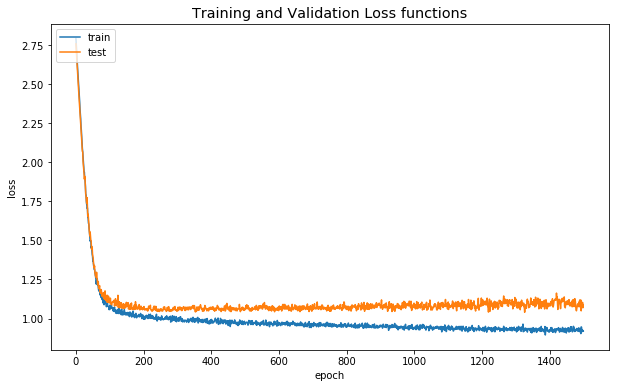

In [12]:
nn_pred = trace_classification.neural_net_classifier(X_train, y_train, X_test, y_test, '3classes', batch_size=128)
nn_results, nn_confusion_matrix = trace_classification.test_metrics('neural network', y_test, nn_pred)
nn_results

### Unsupervised Algorithms

Now we can try to model the problem as an unsupervised learning problem. First, we apply a PCA transformation to collapse the set of datapoints to a 3D space.

In [8]:
X_pca = trace_classification.pca_transformation(X, n_components=len(X.columns)-2)
X_pca.head()

,0,1,2,3,4,5,6
0,-0.464884,-0.155741,0.013294,0.118128,0.030871,-0.019526,-0.008326
1,-0.210911,-0.247682,-0.148636,0.094512,0.048256,0.018775,0.010837
2,-0.465876,-0.087463,-0.109060,-0.108120,-0.008949,0.016963,-0.000765
3,-0.672139,0.006669,0.165008,0.126503,0.014422,0.025449,0.000914
4,-0.293400,0.044271,-0.079797,-0.106448,-0.037060,0.039648,0.013567


5. Let us try modeling the problem with **K-Means**.

,model,accuracy,precision,recall,f1-score,auc roc
0,kmeans,0.382353,0.398697,0.395477,0.377449,0.546899


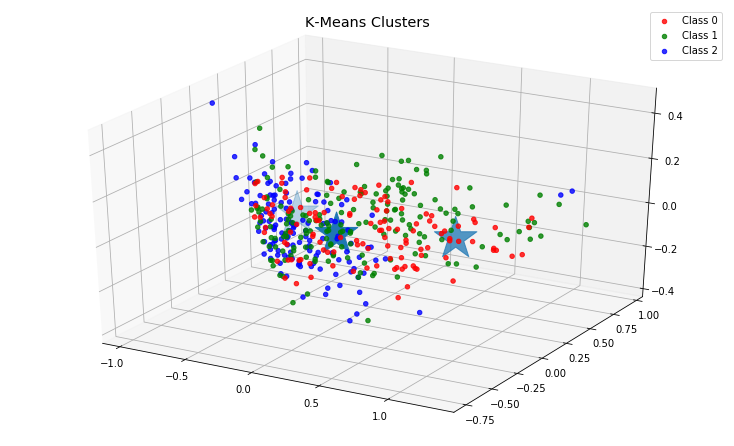

In [9]:
kmeans_pred, centroids = trace_classification.kmeans_classifier(X_pca, n_clusters=3)
data_visualization.plot_3d_points(X_pca[0], X_pca[1], X_pca[3], y, plot_name='KMeans_K3', centroids=centroids)
kmeans_results, kmeans_confusion_matrix = trace_classification.test_metrics('kmeans', y, kmeans_pred)
kmeans_results

## Conclusions

Let us compare the results obtained from the experiment.

In [13]:
final_results= pd.DataFrame(columns=['model','accuracy','precision','recall','f1-score','auc roc'])
final_results = pd.concat([final_results, knn_results])
final_results = pd.concat([final_results, rfc_results])
final_results = pd.concat([final_results, svm_results])
final_results = pd.concat([final_results, nn_results])
final_results = pd.concat([final_results, kmeans_results])
final_results.reset_index(drop=True)

,model,accuracy,precision,recall,f1-score,auc roc
0,knn,0.617978,0.616239,0.630215,0.616850,0.719779
1,random forest,0.629213,0.664057,0.609574,0.615741,0.707926
2,svm,0.584270,0.618070,0.582345,0.577052,0.684210
3,neural network,0.550562,0.556948,0.538867,0.505706,0.653993
4,kmeans,0.382353,0.398697,0.395477,0.377449,0.546899


**KNN** and **random forests** are still the best models.

# References

1. *Deep Learning for Detection of Routing Attacks in the Internet of Things*, International Journal of Computational Intelligence Systems (2018), by Furkan Yusuf Yavuz, Devrim Ünal and Ensar Gul
2. *Machine Learning in IoT Security:Current Solutions and Future Challenges*, arXiv:1904.05735v1 (Mar 2019), by Fatima Hussain, Rasheed Hussain, Syed Ali Hassan, and Ekram Hossain.
3. *Almost Everything You Need to Know About Time Series*, https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578, by Marco Peixeiro
4. *How to Check if Time Series Data is Stationary with Python*, https://machinelearningmastery.com/time-series-data-stationary-python/, by Jason Brownlee
5. *K-Means Clustering in Python*, https://mubaris.com/posts/kmeans-clustering/, by Mubaris NK
6. *AUC ROC Curve Scoring Function for Multi-class Classification*, https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659, by Eric Plog